# Group 7 Notebook 2: Predictivity Analysis



This notebook gives an analysis of the predictivity of the three different classifiers (SVM, Random Forest, and K-Nearest Neighbours) fitted using a variety of methods. 



## Process
1. k value optimisation using cross_val_score with a range of k value specified by users. This will loop for ten times and the most frequent k value is guaranteed to be the most stable and a better one.
2. Optain score with default hyperparameters and plot confusion matrix.
3. Hyperparameter optimisation using GridSearch CV with the k value optained at the first step. These parameters are then used with the classifier to get an optimal accuracy score.
4. Results are compared and the best classifier is identified.

## Settup and Explaination

GridSearchCV basically uses a different combination of all the specified hyperparameters and their values and calculates the performance for each combination and selects the best value for the hyperparameters. Different Classsifiers have different arguments that we can specify. the GridSearchCV_optimisation function in Classifier class includes each parameter grid for each classifier. The function would run through them and give us the optimal hyperparameters for that classifier.


In [28]:
# import basic libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statistics
from statistics import mode

# import classifier libraries
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

# import other sklearn libraries
import sklearn
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV

In [51]:
class Classifier:
    """Container for analysing the dataset using different classification models."""
    def __init__(self, estimator, fname: str, **kwargs):
        
        # initialise the classifier
        self.estimator = estimator(**kwargs)
        
        # import csv as a dataframe and tag rows containing '-' as missing values
        self.df = pd.read_csv(fname, na_values=['-'])
        
    def clean_up(self):
        """Remove rows with mising data and invalid data."""
        
        # drop missing value and reset index
        self.df.dropna(inplace=True)
        self.df.reset_index(drop=True, inplace=True)
        
        # drop rows that don't satisfy the second requirement
        for index in self.df.index:
            total_valency = int(self.df['v(A)'][index]) + int(self.df['v(B)'][index])
            if total_valency != 6:
                self.df.drop(index, inplace=True)
            if not (0.82 < float(self.df['tG'][index]) < 1.1) or not (0.414 < float(self.df['μ'][index]) < 0.732):
                self.df.drop(index, inplace=True)
                
        self.df.reset_index(drop=True, inplace=True)
        
    def run_classifier(self):
        """Sets the feature and target columns, performs the training/testing split, and fits the classifier."""
        
        # set feature columns as every column besides the 'Compound', 'A', 'B', and 'Lowest distortion' columns
        self.X = self.df.drop(['Compound', 'A', 'B', 'Lowest distortion'], axis=1)
        
        # drop highly correlated features
        self.X = self.X.drop(['v(B)', 'r(AVI)(Å)'], axis=1)
        
        # feature scaling for X using min-max scaling
        self.X = MinMaxScaler().fit_transform(self.X)
        
        # set target column as the 'Lowest distortion' column
        self.y = self.df['Lowest distortion']
        
        # training and testing split with random ratio
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(self.X, self.y, test_size=0.2, random_state=1)
        
        # fit training set to estimator
        self.estimator.fit(self.X_train, self.y_train)
        
        # generate prediction set
        self.y_pred = self.estimator.predict(self.X_test)
    
    def score(self):
        """Returns the accuracy score of the latest prediction."""
        return accuracy_score(self.y_test, self.y_pred)
    
    def GridSearchCV_optimisation(self): 
        """Hyperparameters Optimisation Using GridSearch CV"""
        
        # Identify which classifier is used
        if isinstance(self.estimator, sklearn.svm._classes.SVC):
               
            # Parameter range
            self.parameters = [
                {'C':[100, 1000, 1200], 'kernel':['linear']},
                {'C':[100, 1000, 1200], 'kernel':['rbf'], 'gamma':[0.1, 0.2, 0.3, 0.4, 0.5]},
                {'C':[100, 1000, 1200], 'kernel':['poly'], 'degree': [2,3,4] ,'gamma':[0.01,0.02,0.03]}
            ]

            self.grid_search = GridSearchCV(estimator = self.estimator,  
                                       param_grid = self.parameters,
                                       scoring = 'accuracy',
                                       cv = self.best_k,
                                       verbose=0)

           
        elif isinstance(self.estimator, sklearn.ensemble._forest.RandomForestClassifier):

            self.param_grid = {
                'bootstrap': [True, False],
                'max_depth': [10, 30, 40],
                'max_features': [1, 3, 4],
                'min_samples_leaf': [1, 2, 5],
                'min_samples_split': [6, 7, 8, 9],
                'n_estimators': [10, 13, 25]
            }
            
            self.grid_search = GridSearchCV(
                estimator = self.estimator, 
                param_grid = self.param_grid, 
                cv = self.best_k, 
                n_jobs = -1, 
                verbose = 2, 
                scoring = 'accuracy'
            )

        elif isinstance(self.estimator, sklearn.neighbors._classification.KNeighborsClassifier):
            
            self.param_grid = {
                'n_neighbors': list(range(20, 25)),
                'leaf_size': list(range(15, 21)),
                'p': (1, 2),
                'weights': ['uniform', 'distance'],
                'metric': ('minkowski', 'chebyshev')
            }
            
            self.grid_search = GridSearchCV(
                estimator = self.estimator, 
                param_grid = self.param_grid,
                cv=self.best_k, 
                scoring='accuracy', 
                return_train_score=False
            )
            
        self.grid_search.fit(self.X_train, self.y_train)
        
        return self.grid_search.best_params_, self.grid_search.score(self.X_test, self.y_test)
    
    def cross_val_score_opt(self, k1, k2, plot = False):
        """Using cross_val_score to find the best k value"""
        # loop ten times for more accuracy on which k value would perform better
        
        for i in range(10):
            
            # initialise a dictionary and two lists that would store the values
            score_dict = {'number of k': [], 'val_score': []}
            best_k_list = []
            best_score_list = []
            
            # loop over the provided range of k
            for j in np.arange(k1, k2, 1):
                scores = cross_val_score(self.estimator, self.X_train, self.y_train, scoring='accuracy', cv=StratifiedKFold(n_splits = j, shuffle=True), n_jobs=-1) 
                score_dict['val_score'].append(scores.mean())
                score_dict['number of k'].append(j)
                df_data = pd.DataFrame(score_dict)
            
            # best k of one iteration
            _best_k = df_data['number of k'][df_data[df_data['val_score'] == max(df_data['val_score'])].index[0]]
            best_k_list.append(_best_k)
        
        # the most frequent k value in the list which means this k results in best score most of the time
        self.best_k = mode(best_k_list)

        return self.best_k
        
    def confusion(self, **kwargs):
        """Plots the confusion matrix of the chosen classifier."""
        result = confusion_matrix(self.y_test, self.y_pred)

        # Define the plot
        fig, ax = plt.subplots(figsize = (13,7))

        # Add title to the heatmap
        title = f"{self.estimator} Confusion Matrix"
        
        # Add label to the axis
        x_axis_labels = ['cubic', 'orthorhombic', 'rhombohedral', 'tetragonal']
        y_axis_labels = ['cubic', 'orthorhombic', 'rhombohedral', 'tetragonal']

        # Set the font size and the distance of the title from the plot
        plt.title(title, fontsize = 18)

        # Hide ticks for X & Y axis
        ax.set_xticks([])
        ax.set_yticks([])        

        # Remove the axes
        ax.axis('on')
        
        heatmap = sns.heatmap(result/np.sum(result), cmap = "RdPu", annot = True, fmt = '.2%', cbar = True, xticklabels=x_axis_labels, yticklabels=y_axis_labels)
        
        return 

        

## Execution

Here after defining the Classifier class, we first import the data and decide which classifier should be used. Then, the data will be cleaned up and the model will be trained. The score with default setting is obtained. With the trained model, the confusion matrix is plotted. Then, we cross validate it using different k values of k-fold to obtain an optimal k. Finally, we use GridSearchCV to optimise the default settings of hyperparameters.

Then, repeat this for different classifiers.

Randomforest accuracy score with default hyperparameters: 0.7333
Fitting 3 folds for each of 648 candidates, totalling 1944 fits
Best Hyperparameters with score are: ({'bootstrap': False, 'max_depth': 10, 'max_features': 1, 'min_samples_leaf': 1, 'min_samples_split': 6, 'n_estimators': 13}, 0.7037037037037037)
SVC accuracy score with default hyperparameters: 0.6370
Best Hyperparameters with score are: ({'C': 100, 'gamma': 0.5, 'kernel': 'rbf'}, 0.6962962962962963)
KNN accuracy score with default hyperparameters: 0.6963
Best Hyperparameters with score are: ({'leaf_size': 15, 'metric': 'minkowski', 'n_neighbors': 21, 'p': 1, 'weights': 'distance'}, 0.6962962962962963)
CPU times: total: 19.1 s
Wall time: 40.4 s


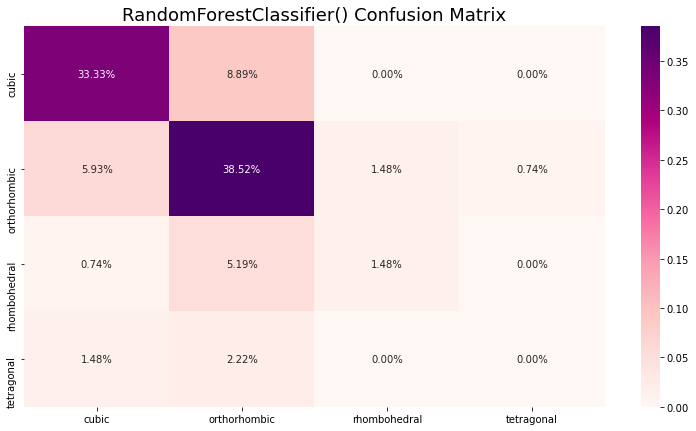

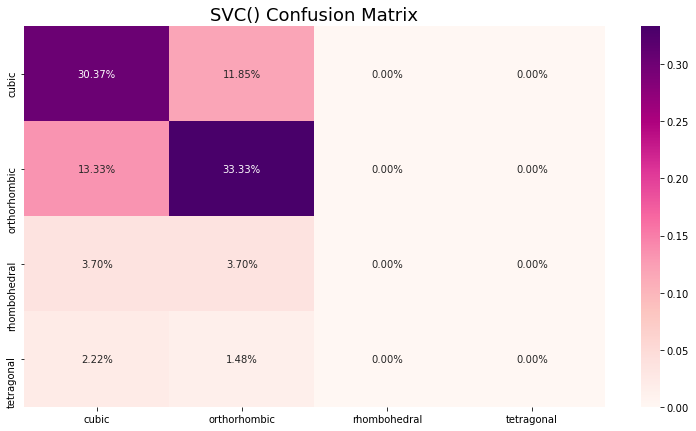

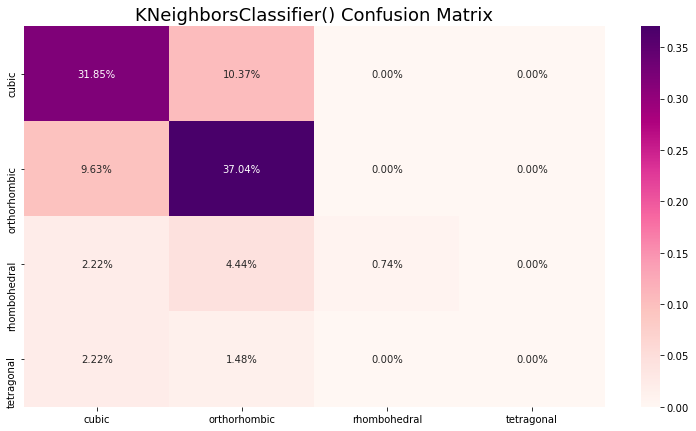

In [52]:
%%time
# RandomForestClassifier
foo = Classifier(RandomForestClassifier, 'Crystal_structure.csv')
foo.clean_up()
foo.run_classifier()
print('Randomforest accuracy score with default hyperparameters: {0:0.4f}'.format(foo.score()))
foo.confusion()
foo.cross_val_score_opt(3, 7)
print(f'Best Hyperparameters with score are: {foo.GridSearchCV_optimisation()}')

# SVC
fo1 = Classifier(SVC, 'Crystal_structure.csv')
fo1.clean_up()
fo1.run_classifier()
print('SVC accuracy score with default hyperparameters: {0:0.4f}'.format(fo1.score()))
fo1.confusion()
fo1.cross_val_score_opt(3, 7)
print(f'Best Hyperparameters with score are: {fo1.GridSearchCV_optimisation()}')

# KNN
fo2 = Classifier(KNeighborsClassifier, 'Crystal_structure.csv')
fo2.clean_up()
fo2.run_classifier()
print('KNN accuracy score with default hyperparameters: {0:0.4f}'.format(fo2.score()))
fo2.confusion()
fo2.cross_val_score_opt(3, 7)
print(f'Best Hyperparameters with score are: {fo2.GridSearchCV_optimisation()}')

# Result

Based on the previous cell output, we can see that the optimised score of classifiers are:

| RandomForest | SVM | KNN |
| -: | -: | -: |
| 0.7555 | 0.6962 | 0.6962

Compared to the original score, KNN boosts the most. However, the best score is still RandomForestClassifier, which has the best hyperparameters:

| bootstrap | max_depth | max_features | min_samples_leaf | min_samples_split | n_estimators |
| -: | -: | -: | -: | -: | -: |
| False | 30 | 3 | 2 | 8 | 13 |

